<!--NOTEBOOK_HEADER-->
*This notebook contains material from [ND Pyomo Cookbook](http://jckantor.github.io/ND-Pyomo-Cookbook/) by 
Jeffrey Kantor (jeff at nd.edu); the content is available [on GitHub](https://github.com/jckantor/ND-Pyomo-Cookbook).
*The text is released under the [CC-BY-NC-ND-4.0 license](https://creativecommons.org/licenses/by-nc-nd/4.0/legalcode),
and code is released under the [MIT license](https://opensource.org/licenses/MIT).*


<!--NAVIGATION-->
< [Linear Blending Problem](http://nbviewer.jupyter.org/github/jckantor/ND-Pyomo-Cookbook/blob/master/notebooks/02.02-Linear-Blending-Problem.ipynb) | [Contents](toc.ipynb) | [Gasoline Blending](http://nbviewer.jupyter.org/github/jckantor/ND-Pyomo-Cookbook/blob/master/notebooks/02.04-Gasoline-Blending.ipynb) ><p><a href="https://colab.research.google.com/github/jckantor/ND-Pyomo-Cookbook/blob/master/notebooks/02.03-Mixture-Design-Cold-Weather-Fuel.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a>

# Design of a Cold Weather Fuel for a Camping Stove

## Problem Statement

The venerable alcohol stove has been invaluable camping accessory for generations. They are simple, reliable, and in a pinch, can be made from aluminum soda cans. 

![alcohol-stove.jpeg](https://github.com/jckantor/ND-Pyomo-Cookbook/blob/master/images/alcohol-stove.jpeg?raw=1)

Alcohol stoves are typically fueled with denatured alcohol. Denatured alcohol, sometimes called methylated spirits, is a generally a mixture of ethanol and other alcohols and compounds designed to make it unfit for human consumption. An MSDS description of one [manufacturer's product](https://www.korellis.com/wordpress/wp-content/uploads/2016/05/Alcohol-Denatured.pdf) describes a roughly fifity/fifty mixture of ethanol and methanol.

The problem with alcohol stoves is they can be difficult to light in below freezing weather. The purpose of this notebook is to design of an alternative cold weather fuel that could be mixed from other materials commonly available from hardware or home improvement stores.

In [ ]:
!pip install -q pyomo
!apt-get install -y -qq coinor-cbc

## Vapor Pressure Data

The following data was collected for potential fuels commonly available at hardware and home improvement stores. The data consists of price (\$/gal.) and parameters to predict vapor pressure using the Antoine equation,

\begin{align}
\log_{10}P^{vap}_{s}(T) & = A_s - \frac{B_s}{T + C_s}
\end{align}

where the subscript $s$ refers to species, temperature $T$ is in units of degrees Celcius, and pressure $P$ is in units of mmHg. The additional information for molecular weight and specific gravity will be needed to present the final results in volume fraction.

In [1]:
data = {
    'ethanol'          : {'MW':  46.07, 'SG': 0.791, 'A': 8.04494, 'B': 1554.3,  'C': 222.65},
    'methanol'         : {'MW':  32.04, 'SG': 0.791, 'A': 7.89750, 'B': 1474.08, 'C': 229.13},
    'isopropyl alcohol': {'MW':  60.10, 'SG': 0.785, 'A': 8.11778, 'B': 1580.92, 'C': 219.61},
    'acetone'          : {'MW':  58.08, 'SG': 0.787, 'A': 7.02447, 'B': 1161.0,  'C': 224.0},
    'xylene'           : {'MW': 106.16, 'SG': 0.870, 'A': 6.99052, 'B': 1453.43, 'C': 215.31},
    'toluene'          : {'MW':  92.14, 'SG': 0.865, 'A': 6.95464, 'B': 1344.8,  'C': 219.48},
}

The first step is to determine the vapor pressure of denatured alcohol over a typical range of operating temperatures. For this we assume denatured alcohol is a 40/60 (mole fraction) mixture of ethanol and methanol. 

Vapor Pressure at 0C = 22.1 mmHg


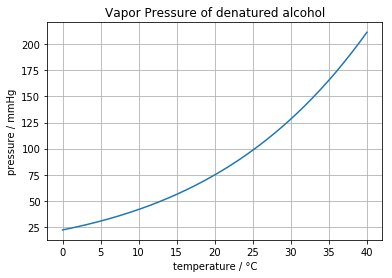

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def Pvap(T, s):
    return 10**(data[s]['A'] - data[s]['B']/(T + data[s]['C']))

def Pvap_denatured(T):
    return 0.4*Pvap(T, 'ethanol') + 0.6*Pvap(T, 'methanol')

T = np.linspace(0, 40, 200)

plt.plot(T, Pvap_denatured(T))
plt.title('Vapor Pressure of denatured alcohol')
plt.xlabel('temperature / °C')
plt.ylabel('pressure / mmHg')
print("Vapor Pressure at 0C =", round(Pvap_denatured(0),1), "mmHg")
plt.grid(True)

## Cold Weather Product Requirements

We seek a cold weather fuel with increased vapor pressure at 0°C and lower, and also provides safe and normal operation of the alcohol stove at higher operating temperatures. 

For this purpose, we seek a mixture of commonly available liquids with a vapor pressure of at least 22 mmHg at the lowest possible temperature, and no greater than the vapor pressure of denatured alcohol at temperatures 30°C and above.

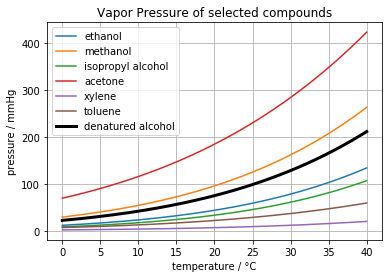

In [4]:
for s in data.keys():
    plt.plot(T, Pvap(T,s))
plt.plot(T, Pvap_denatured(T), 'k', lw=3)
plt.legend(list(data.keys()) + ['denatured alcohol'])
plt.title('Vapor Pressure of selected compounds')
plt.xlabel('temperature / °C')
plt.ylabel('pressure / mmHg')
plt.grid(True)

## Optimization Model

The first optimization model is to create a mixture that maximizes the vapor pressure at -10°C while having a vapor pressure less than or equal to denatured alcohol at 30°C and above. 

The decision variables in the optimization model correspond to $x_s$, the mole fraction of each species $s \in S$ from the set of available species $S$. By definition, the mole fractions must satisfy

\begin{align}
x_s & \geq 0 & \forall s\in S \\
\sum_{s\in S} x_s & = 1
\end{align}

The objective is to maximize the vapor pressure at low temperatures, say -10°C, while maintaing a vapor pressure less than or equal to denatured alcohol at 30°C. Using Raoult's law for ideal mixtures,

\begin{align}
\max_{x_s} \sum_{s\in S} x_s P^{vap}_s(-10°C) \\
\end{align}
subject to
\begin{align}
\sum_{s\in S} x_s P^{vap}_s(30°C) & \leq P^{vap}_{denatured\ alcohol}(30°C) \\
\end{align}

## Pyomo Implementation and Solution

This optimization model is implemented in Pyomo in the following cell.

Vapor Pressure at -10°C = 17.48178543436185 mmHg


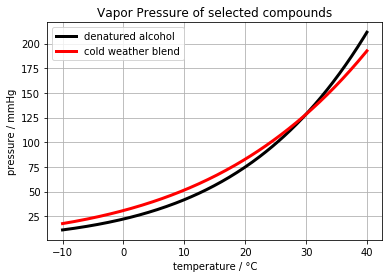

In [5]:
import pyomo.environ as pyomo

m = pyomo.ConcreteModel()

S = data.keys()
m.x = pyomo.Var(S, domain=pyomo.NonNegativeReals)

def Pmix(T):
    return sum(m.x[s]*Pvap(T,s) for s in S)

m.obj = pyomo.Objective(expr = Pmix(-10), sense=pyomo.maximize)

m.cons = pyomo.ConstraintList()

m.cons.add(sum(m.x[s] for s in S)==1)
m.cons.add(Pmix(30) <= Pvap_denatured(30))
m.cons.add(Pmix(40) <= Pvap_denatured(40))

solver = pyomo.SolverFactory('cbc')
solver.solve(m)

print("Vapor Pressure at -10°C =", m.obj(), "mmHg")

T = np.linspace(-10,40,200)
plt.plot(T, Pvap_denatured(T), 'k', lw=3)
plt.plot(T, [Pmix(T)() for T in T], 'r', lw=3)
plt.legend(['denatured alcohol'] + ['cold weather blend'])
plt.title('Vapor Pressure of selected compounds')
plt.xlabel('temperature / °C')
plt.ylabel('pressure / mmHg')
plt.grid(True)

The Pandas library is useful for summarizing the solution in tabular form.

In [6]:
import pandas as pd

s = data.keys()
results = pd.DataFrame.from_dict(data).T
for s in S:
    results.loc[s,'mole fraction'] = m.x[s]()
    
MW = sum(m.x[s]()*data[s]['MW'] for s in S)
for s in S:
    results.loc[s,'mass fraction'] = m.x[s]()*data[s]['MW']/MW
    
vol = sum(m.x[s]()*data[s]['MW']/data[s]['SG'] for s in S)
for s in S:
    results.loc[s,'vol fraction'] = m.x[s]()*data[s]['MW']/data[s]['SG']/vol

results

,A,B,C,MW,SG,mole fraction,mass fraction,vol fraction
ethanol,8.04494,1554.30,222.65,46.07,0.791,0.000000,0.0000,0.000000
methanol,7.89750,1474.08,229.13,32.04,0.791,0.000000,0.0000,0.000000
isopropyl alcohol,8.11778,1580.92,219.61,60.10,0.785,0.000000,0.0000,0.000000
acetone,7.02447,1161.00,224.00,58.08,0.787,0.428164,0.2906,0.311695
xylene,6.99052,1453.43,215.31,106.16,0.870,0.571836,0.7094,0.688305
toluene,6.95464,1344.80,219.48,92.14,0.865,0.000000,0.0000,0.000000


<!--NAVIGATION-->
< [Linear Blending Problem](http://nbviewer.jupyter.org/github/jckantor/ND-Pyomo-Cookbook/blob/master/notebooks/02.02-Linear-Blending-Problem.ipynb) | [Contents](toc.ipynb) | [Gasoline Blending](http://nbviewer.jupyter.org/github/jckantor/ND-Pyomo-Cookbook/blob/master/notebooks/02.04-Gasoline-Blending.ipynb) ><p><a href="https://colab.research.google.com/github/jckantor/ND-Pyomo-Cookbook/blob/master/notebooks/02.03-Mixture-Design-Cold-Weather-Fuel.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a>